# chestMNIST

In this Jupyter notebook, you will work withe the chestMNIST dataset from the medMNIST dataset collection. It contains images of pediatric chest X-rays, that were labeled with the presence of pneumonia

## Import dataset

First, the dataset is imported using functions that come with the medmnist package.

This result in a training, testing and validation set. For each, X is an array (#samples, 28, 28, 1) of 28x28 images and y is an array (#samples,1) that containes the labels: 0 means normal, 1 means pneunomia.

In [ ]:
from tqdm import tqdm
import numpy as np

import medmnist
#from medmnist import INFO, Evaluator
from medmnist import INFO
import dataset_without_pytorch
from dataset_without_pytorch import get_loader

from tensorflow import keras
from matplotlib import pyplot as plt

data_flag = 'pneumoniamnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(dataset_without_pytorch, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download)
test_dataset = DataClass(split='val', download=download)
val_dataset = DataClass(split='test', download=download)

# extract images and labels, dimensions are expanded to work with convoltion layers
X_train = train_dataset.imgs
X_train = np.expand_dims(X_train, axis=3)
y_train = train_dataset.labels

X_val = val_dataset.imgs
X_val = np.expand_dims(X_val, axis=3)
y_val = val_dataset.labels

X_test = test_dataset.imgs
X_test = np.expand_dims(X_test, axis=3)
y_test = test_dataset.labels

### This functions shows a montage of input images

/usr/local/lib/python3.9/site-packages/medmnist/utils.py:25: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


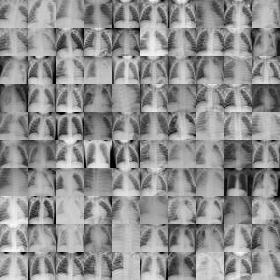

In [2]:
# montage
train_dataset.montage(length=10)

## First approach

As a first approach, we will build a simple model.

### Define

Define the model, it should have the follwing layers:

1. Flatten layer (convert input of 28x28 images to a 784-1D input)
2. Dense layer with 100 neurons and ReLu activation function
3. Dense layer with 10 neurons and ReLu activation function
4. Dense layer with 1 neuron and Sigmoid (why) activation function

In [3]:
model = keras.Sequential()

model.add(keras.layers.Flatten(input_shape=(28,28, 1)))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

2022-04-08 16:07:58.445636: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Train

Now that the model is defined, you can compile and train it.
- Compile the model using "sgd" optimizer and BinaryCrossentropy loss, BinaryAccuracy should be calculated as an additional metric. BinaryCrossentropy is used for binary (0 or 1) classification applications.
-  Fit the model for 10 epochs using the training data, also hand over the valdation set as validation data.

In [4]:
model.compile(optimizer="sgd", 
              loss=keras.losses.BinaryCrossentropy(), 
              metrics=[keras.metrics.BinaryAccuracy()])


historyFirst = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=8,
    validation_data=(X_val, y_val),
)

Epoch 1/10
589/589 [==============================] - 1s 2ms/step - loss: 0.7463 - binary_accuracy: 0.7339 - val_loss: 0.6652 - val_binary_accuracy: 0.6250
Epoch 2/10
589/589 [==============================] - 1s 1ms/step - loss: 0.6034 - binary_accuracy: 0.7421 - val_loss: 0.6637 - val_binary_accuracy: 0.6250
Epoch 3/10
589/589 [==============================] - 1s 1ms/step - loss: 0.5804 - binary_accuracy: 0.7421 - val_loss: 0.6740 - val_binary_accuracy: 0.6250
Epoch 4/10
589/589 [==============================] - 1s 1ms/step - loss: 0.5733 - binary_accuracy: 0.7421 - val_loss: 0.6829 - val_binary_accuracy: 0.6250
Epoch 5/10
589/589 [==============================] - 1s 2ms/step - loss: 0.5715 - binary_accuracy: 0.7421 - val_loss: 0.6881 - val_binary_accuracy: 0.6250
Epoch 6/10
589/589 [==============================] - 1s 2ms/step - loss: 0.5711 - binary_accuracy: 0.7421 - val_loss: 0.6910 - val_binary_accuracy: 0.6250
Epoch 7/10
589/589 [==============================] - 1s 2ms/ste

### Evaluate

Evaluate the model. Is it suitable?

17/17 [==============================] - 0s 2ms/step - loss: 0.5706 - binary_accuracy: 0.7424
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


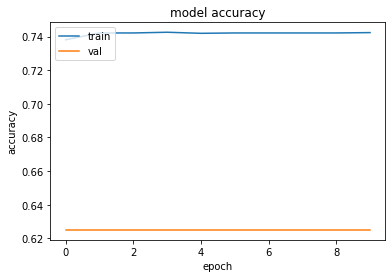

In [8]:
scoreFirst = model.evaluate(X_test, y_test)

print(historyFirst.history.keys())

plt.plot(historyFirst.history['binary_accuracy'])
plt.plot(historyFirst.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## A CNN

Because the first approch was not suited properly, you will now use a CNN.

### Define

Define the model, it should have the follwing layers:

1. Input, to tell Keras which size the input has. This layers is not mandatory, but summary() wont work without it.
2. Conv2D, 6 feature maps, 5x5 kernel, (1,1) stride, 'same' padding (fill with zeros), ReLu activation
3. AveragePooling2D, 2x2 pool size, (2,2) stride, 'valid' padding (no padding)
4. Conv2D, 16 feature maps, 5x5 kernel, (1,1) stride, 'valid' padding, ReLu activation
5. AveragePooling2D, 2x2 pool size, (2,2) stride, 'valid' padding (no padding)
6. Conv2D, 40 feature maps, 5x5 kernel, (1,1) stride, 'valid' padding, ReLu activation
7. Flatten
8. Dense, 60 neurons, ReLu activation
9. Dropout 50%
10. Dense, 1 neuron, Sigmoid activation

In [9]:
cnn = keras.Sequential()

cnn.add(keras.Input(shape=(28,28, 1)))

cnn.add(keras.layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"))
cnn.add(keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

cnn.add(keras.layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))
cnn.add(keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

cnn.add(keras.layers.Conv2D(40, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))

cnn.add(keras.layers.Flatten())
cnn.add(keras.layers.Dense(60, activation='relu'))
cnn.add(keras.layers.Dropout(0.5))
cnn.add(keras.layers.Dense(1, activation='sigmoid'))

cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 40)          16040     
                                                                 
 flatten_2 (Flatten)         (None, 40)               

#### Train

Train the CNN for 10 epochs. Use "adam" optimizer and don't forget the valdiation set.

In [10]:
cnn.compile(optimizer="adam", 
              loss=keras.losses.BinaryCrossentropy(), 
              metrics=[keras.metrics.BinaryAccuracy()])


historyCNN = cnn.fit(
    X_train, y_train,
    epochs=10,
    batch_size=8,
    validation_data=(X_val, y_val),
)

Epoch 1/10
589/589 [==============================] - 3s 4ms/step - loss: 0.4133 - binary_accuracy: 0.8636 - val_loss: 0.4073 - val_binary_accuracy: 0.8397
Epoch 2/10
589/589 [==============================] - 2s 4ms/step - loss: 0.2107 - binary_accuracy: 0.9186 - val_loss: 0.4997 - val_binary_accuracy: 0.8221
Epoch 3/10
589/589 [==============================] - 2s 4ms/step - loss: 0.1713 - binary_accuracy: 0.9325 - val_loss: 0.7268 - val_binary_accuracy: 0.8141
Epoch 4/10
589/589 [==============================] - 2s 4ms/step - loss: 0.1412 - binary_accuracy: 0.9482 - val_loss: 0.6708 - val_binary_accuracy: 0.8301
Epoch 5/10
589/589 [==============================] - 2s 4ms/step - loss: 0.1406 - binary_accuracy: 0.9499 - val_loss: 0.5145 - val_binary_accuracy: 0.8622
Epoch 6/10
589/589 [==============================] - 2s 4ms/step - loss: 0.1126 - binary_accuracy: 0.9584 - val_loss: 0.8439 - val_binary_accuracy: 0.8317
Epoch 7/10
589/589 [==============================] - 2s 4ms/ste

### Evaluate

Evaluate the model.

In [11]:
scoreCNN = cnn.evaluate(X_test, y_test)

print(historyCNN.history.keys())

plt.plot(historyCNN.history['binary_accuracy'])
plt.plot(historyCNN.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

17/17 [==============================] - 0s 4ms/step - loss: 0.1094 - binary_accuracy: 0.9561
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


## Playground

Try to build your own model. A good model should match the follwing requirements:

- as small as possible -> faster training
- generalize well -> not overfiiting the training data
- of course: achive high accuracy

### Define

In [ ]:
mymodel = keras.Sequential()

# be creative!

### Train

Train you model.

You can also try different optimizers (sgd, adam, ...), see the [keras documentation](https://keras.io/api/) for more.

In [ ]:
mymodel.compile(optimizer="sdg", 
              loss=keras.losses.BinaryCrossentropy(), 
              metrics=[keras.metrics.BinaryAccuracy()])


historyMY = mymodel.fit(
    X_train, y_train,
    epochs=10,
    batch_size=8,
    validation_data=(X_val, y_val),
)

### Evalaute

How does you model perform?

In [ ]:
scoreMy = model.evaluate(X_test, y_test)

print(historyMY.history.keys())

plt.plot(historyMY.history['binary_accuracy'])
plt.plot(historyMY.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()